# 3D Stellar wind

---
In this example, we consider an smoothed-particle hydrodynamics (SPH) model of a companion-perturbed stellar wind.

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import os
from astropy import units, constants


---

## Model setup
First we download a snapshot of this SPH model.

In [2]:
setup_file = '3D_stellar_wind_data/wind.setup'
input_file = '3D_stellar_wind_data/wind.in'
dump_file  = '3D_stellar_wind_data/wind.dump'

In [3]:
!wget 'https://raw.githubusercontent.com/Ensor-code/phantom-models/main/Malfait%2B2024a/v10e00/wind.setup'  --output-document $setup_file
!wget 'https://raw.githubusercontent.com/Ensor-code/phantom-models/main/Malfait%2B2024a/v10e00/wind.in'     --output-document $input_file
!wget 'https://raw.githubusercontent.com/Ensor-code/phantom-models/main/Malfait%2B2024a/v10e00/wind_v10e00' --output-document $dump_file

--2024-08-12 08:55:22--  https://raw.githubusercontent.com/Ensor-code/phantom-models/main/Malfait%2B2024a/v10e00/wind.setup
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1209 (1.2K) [text/plain]
Saving to: ‘3D_stellar_wind_data/wind.setup’

3D_stellar_wind_dat 100%[===================>]   1.18K  --.-KB/s    in 0s      

2024-08-12 08:55:22 (38.8 MB/s) - ‘3D_stellar_wind_data/wind.setup’ saved [1209/1209]

--2024-08-12 08:55:23--  https://raw.githubusercontent.com/Ensor-code/phantom-models/main/Malfait%2B2024a/v10e00/wind.in
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP reques

We use [plons](https://github.com/Ensor-code/plons) to open the data.

In [4]:
import plons

setupData = plons.LoadSetup(f'{os.getcwd()}/3D_stellar_wind_data', 'wind')
dumpData  = plons.LoadFullDump(f'{os.getcwd()}/{dump_file}', setupData)

position = dumpData["position"]*1e-2   # position vectors [cm   -> m]
velocity = dumpData["velocity"]*1e3    # velocity vectors [km/s -> m/s]
rho      = dumpData["rho"]             # density          [g/cm^3]
tmp      = dumpData["Tgas"]            # temperature      [K]
tmp[tmp<2.7] = 2.7                     # Cut-off temperatures below 2.7 K

# Unpack velocities
v_x, v_y, v_z = velocity.T

# Convert rho (total density) to H2 abundance
nH2 = rho * 1.0e+6 * constants.N_A.si.value / 2.02

# Define turbulence at 150 m/s
v_trb = 150.0

Next, we map the particle data to a regular Cartesian mesh.

In [5]:
from pomme.haar import Haar

# Map point data to a regular grid
haar = Haar(position, q=8)
# Zoom in on the centre region to avoid edge effects
imin = 2**(haar.q-3)
imax = 3*imin
# Map data to a regular grid
nH2_dat = haar.map_data(nH2, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
tmp_dat = haar.map_data(tmp, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_x_dat = haar.map_data(v_x, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_y_dat = haar.map_data(v_y, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_z_dat = haar.map_data(v_z, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]

---

### TensorModel
With all the data in place, we can start building a pomme model.
First, we store all model parameters as a TensorModel object and store this in an HDF5 file.
We will use this later as the ground truth to verify our reconstructions against.

In [6]:
from pomme.model import TensorModel

model = TensorModel(shape=nH2_dat.shape, sizes=haar.xyz_L)
model['log_H2'          ] = np.log(nH2_dat).astype(np.float64)
model['log_temperature' ] = np.log(tmp_dat).astype(np.float64)
model['velocity_x'      ] =        v_x_dat .astype(np.float64)
model['velocity_y'      ] =        v_y_dat .astype(np.float64)
model['velocity_z'      ] =        v_z_dat .astype(np.float64)
model['log_v_turbulence'] = np.log(v_trb)*np.ones(model.shape, dtype=np.float64)
model.save('3D_stellar_wind_truth.h5')

---

### GeneralModel
First, we define the functions that can generate the model distributions from the model parameters.

In [7]:
import torch
from pomme.utils import planck, T_CMB

def get_velocity(model):
    """
    Get the velocity from the TensorModel.
    """
    return model['velocity_z']

def get_temperature(model):
    """
    Get the temperature from the TensorModel.
    """
    return torch.exp(model['log_temperature'])

def get_abundance(model, l):
    """
    Get the abundance from the TensorModel.
    """
    # Define the assumed molecular fractions w.r.t. H2
    X_mol = [3.0e-4, 5.0e-6]
    # Return the abundance
    return torch.exp(model['log_H2']) * X_mol[l]

def get_turbulence(model):
    """
    Get the turbulence from the TensorModel.
    """
    return torch.exp(model['log_v_turbulence'])

def get_boundary_condition(model, frequency):
    """
    Get the boundary condition from the TensorModel.
    model: TensorModel
        The TensorModel object containing the model.
    frequency: float
        Frequency at which to evaluate the boundary condition.
    """
    # Compute the incoming boundary intensity
    Ibdy  = torch.ones((model.shape[0], model.shape[1], len(frequency)), dtype=torch.float64)
    Ibdy *= planck(temperature=T_CMB, frequency=frequency)
    # Return the result
    return Ibdy

Using these functions, we can build a GeneralModel object that can be used to generate synthetic observations or reconstruct the required parameters. (Cfr. the SphericalModel class for spherically symmetric models.)

In [8]:
from pomme.model import GeneralModel

gmodel_truth = GeneralModel(model=model)
gmodel_truth.get_velocity           = get_velocity
gmodel_truth.get_abundance          = get_abundance
gmodel_truth.get_turbulence         = get_turbulence
gmodel_truth.get_temperature        = get_temperature
gmodel_truth.get_boundary_condition = get_boundary_condition

---

### Spectral lines
We base our reconstructions on synthetic observations of two commonly observed rotational lines CO $J=4-3$ and SiO $J=3-2$. We explicitly provide the molar mass for SiO, since this is not extracted correctly from the line data file.

In [9]:
from pomme.lines import Line
from pomme.utils import get_molar_mass

lines = [
    Line(species_name='CO',     transition=3),
    Line(species_name='sio-h2', transition=2, molar_mass=get_molar_mass('SiO'))
]

You have selected line:
    CO(J=4-3)
Please check the properties that were inferred:
    Frequency         4.610407682e+11  Hz
    Einstein A coeff  6.126000000e-06  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    sio-h2(J=03-02)
Please check the properties that were inferred:
    Frequency         1.302686830e+11  Hz
    Einstein A coeff  1.058000000e-04  1/s
    Molar mass        44.0849          g/mol


/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


---

### Frequencies
Next, we define the velocity/frequency range.
We observe the lines in 100 frequency bins, centred around the lines, with a spacing of 120 m/s.

In [10]:
vdiff = 120   # velocity increment size [m/s]
nfreq = 100   # number of frequencies

velocities  = nfreq * vdiff * torch.linspace(-1, +1, nfreq, dtype=torch.float64)
frequencies = [(1.0 + velocities / constants.c.si.value) * line.frequency for line in lines]

---

## Synthetic observations
We can now generate synthetic observations, directly from the Model object.
We will use these later to derive our reconstructions.

In [11]:
obss = gmodel_truth.image(lines, frequencies)

Plot the resulting synthetic spectral line observations.
pomme provides some convenient wrappers for matploltib to explore the spectral data cubes.

In [12]:
from pomme.plot import plot_cube_2D, plot_spectrum

plot_cube_2D(np.log(obss[0]))
plot_cube_2D(np.log(obss[1]))

plot_spectrum(np.log(obss[0]))
plot_spectrum(np.log(obss[1]))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

interactive(children=(IntSlider(value=31, description='i', max=63), IntSlider(value=31, description='j', max=6…

interactive(children=(IntSlider(value=31, description='i', max=63), IntSlider(value=31, description='j', max=6…

<function pomme.plot.plot_spectrum.<locals>.plot(i, j)>

---

## Reconstruction setup
In this example, we will try to reconstruct the CO abundance, radial velocity, and temperature distribution.
Since we will only assume a radial component in our velocity field, we need to adapt the corresponding function.

In [13]:
def get_velocity_from_1D(model):
    """
    Get the velocity from the 1D data.
    """ 
    # Extract the radial unit vector field from the model
    d = torch.from_numpy(model.get_radial_direction(origin='centre'))
    # Return the (strictly radial) velocity field
    return torch.exp(model['log_velocity_r']) * d

Next, we define the model object for the reconstruction. Note that in the gmodel defined above, all the right parameters are already stored, so we need a new one for the reconstruction.
We take, $n_{\text{CO}}^{\text{init}}(r) = 5.0 \times 10^{14} \, \text{m}^{-3} \, (r_{\text{in}}/r)^{2} $, as initial guess for the CO abundance distribution, and initialise both the velocity and the temperature with the correct values.

In [14]:
gmodel_recon = GeneralModel(gmodel_truth.model)
gmodel_recon.get_velocity           = get_velocity_from_1D
gmodel_recon.get_abundance          = get_abundance
gmodel_recon.get_turbulence         = get_turbulence
gmodel_recon.get_temperature        = get_temperature
gmodel_recon.get_boundary_condition = get_boundary_condition

# Initial guess parameters
n_H2_in = 5.0e+13
v_in    = 1.0e+2
v_inf   = 1.0e+4
beta    = 1.0
T_in    = 5.0e+3
epsilon = 0.5

rs = gmodel_recon.model.get_radius(origin='centre')

model['log_H2'          ] = np.log(n_H2_in * (rs.min()/rs)**2)
model['log_velocity_r'  ] = np.log(v_in + (v_inf - v_in) * (1.0 - rs.min()/rs)**beta)
model['log_temperature' ] = np.log(T_in * (rs.min()/rs)**epsilon)

# Fix all parameters, except for the ones we want to fit
model.fix_all()
model.free(['log_H2', 'log_velocity_r', 'log_temperature'])

# Save the initial guess
model.save('3D_stellar_wind_recon_init.h5')

We can explore the model parameters with the info() function.

In [15]:
gmodel_recon.model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_H2                     Free          True     +2.326e+01     +2.451e+01     +3.154e+01
  log_temperature            Free          True     +6.446e+00     +6.759e+00     +8.517e+00
  velocity_x                 Fixed         True     -1.958e+04     +4.669e+00     +1.754e+04
  velocity_y                 Fixed         True     -1.741e+04     -2.048e+02     +2.137e+04
  velocity_z                 Fixed         True     -9.749e+03     -7.321e+01     +9.680e+03
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
  log_velocity_r             Free          True     +4.605e+00     +9.178e+00     +9.195e+00
sizes: [7.46717267e+13 7.46169581e+13 7.36127621e+13]
shape: (64, 64, 64)


---

### Loss functions
We first create Loss object that can conveniently store the different losses.
We will use a reproduction loss (split into an averaged and relative component), a smoothness, and a continuity loss.

In [16]:
from pomme.loss import Loss, diff_loss

losses = Loss(['avg', 'rel', 'smt', 'cnt'])

---

#### Reproduction loss
We split the reproduction loss into an averaged and a relative component,
\begin{equation*}
\mathcal{L}_{\text{rep}}\big(f(\boldsymbol{m}), \boldsymbol{o} \big)
\ = \
\mathcal{L}_{\text{rep}}\Big( \big\langle f(\boldsymbol{m}) \big\rangle, \, \left\langle\boldsymbol{o}\right\rangle \Big)
\ + \
\mathcal{L}_{\text{rep}}\left( \frac{f(\boldsymbol{m})}{\big\langle f(\boldsymbol{m})\big\rangle}, \, \frac{\boldsymbol{o}}{\left\langle \boldsymbol{o}\right\rangle} \right) ,
\end{equation*}

In [17]:
# Define averaging and relative function
avg = lambda arr: arr.mean(axis=-1)
rel = lambda arr: torch.einsum("...f, ... -> ...f", arr, 1.0/avg(arr))

def avg_loss(smodel, imgs):
    """
    Compute the average loss.
    """
    return torch.nn.functional.mse_loss(avg(imgs), avg(obss))

def rel_loss(smodel, imgs):
    """
    Compute the relative loss.
    """
    return torch.nn.functional.mse_loss(rel(imgs), rel(obss))

---

#### Smoothness loss
The smoothnes loss is defined as,
\begin{equation}
\mathcal{L}[q] \ = \ \int \text{d} \boldsymbol{x} \ \| \nabla q(\boldsymbol{x})\|^{2}
\end{equation}

In [18]:
def smoothness_loss(gmodel):
    """
    Smoothness loss for CO, velocity, and temperature distributions.
    """
    # Compute and return the loss
    return (   diff_loss(gmodel.model['log_H2'         ]) \
             + diff_loss(gmodel.model['log_velocity_r' ]) \
             + diff_loss(gmodel.model['log_temperature']) )

---

#### Continuity loss
The regularisation loss that assumes a steady state and enforces the continuity equation, in 3D reads,
\begin{equation*}
\mathcal{L}[\rho, \boldsymbol{v}]
\ = \
\int \text{d}\boldsymbol{x} \ \frac{1}{\rho^{2}} \big( \nabla \cdot \left( \rho \, \boldsymbol{v} \right) \big)^{2}
\end{equation*}

In [19]:
def steady_state_cont_loss(gmodel):
    """
    Loss assuming steady state hydrodynamics, i.e. vanishing time derivatives.
    """
    # Extract the relevant variables form the model
    rho           = gmodel.get_abundance(gmodel.model, 0)   # line number does not matter here
    v_x, v_y, v_z = gmodel.get_velocity (gmodel.model)
    # Continuity equation (steady state): div(ρ v) = 0
    loss_cont = gmodel.model.diff_x(rho * v_x) + gmodel.model.diff_y(rho * v_y) + gmodel.model.diff_z(rho * v_z)
    # Squared average over the model
    loss_cont = torch.mean((loss_cont / rho)**2)
    # Return losses
    return loss_cont

---

### Fit function
With everything in place, we can finally define the fit function.

In [20]:
from torch.optim import Adam
from tqdm        import tqdm

def fit(losses, gmodel, N_epochs=10, lr=1.0e-1, w_avg=1.0, w_rel=1.0, w_smt=1.0, w_cnt=1.0):
    # Define optimiser
    optimizer = Adam(model.free_parameters(), lr=lr)
    # Iterate optimiser
    for _ in tqdm(range(N_epochs)):
        # Forward model
        imgs = gmodel.image(lines, frequencies)
        # Compute the losses
        losses['avg'] = w_avg * avg_loss(gmodel, imgs)
        losses['rel'] = w_rel * rel_loss(gmodel, imgs)
        losses['smt'] = w_smt * smoothness_loss(gmodel)
        losses['cnt'] = w_cnt * steady_state_cont_loss(gmodel)
        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        losses.tot().backward()
        # Update parameters
        optimizer.step()
    # Return the images and losses
    return imgs, losses

---

## Experiments

Now we can fit the model to the synthetic data.
First, to determine the relative weights for each loss function in the total loss, we run 3 iterations and observe the loss values. Then, we define the weight of each individual loss function by the inverse of its current value (renormalisation step), such that in the following iterations they all contribute equally.

In [23]:
imgs, losses = fit(losses, gmodel_recon,
    N_epochs = 3,
    lr       = 1.0e-1,
    w_avg    = 1.0e+0,
    w_rel    = 1.0e+0,
    w_smt    = 1.0e+0,
    w_cnt    = 1.0e+0,
)
losses.renormalise_all()   # Renormalise the losses
losses.reset()             # Reset the losses to renormalised values

# Save the (partially) reconstructed model
gmodel_recon.model.save('3D_stellar_wind_recon_000.h5')

100%|██████████| 3/3 [00:42<00:00, 14.11s/it]


With the renormalised weights in place, we now run 100 iterations of the reconstruction algorithm.
Note that one can still specify relative weights for the losses, these are an additional factor to the renormalisation. Here, we take them all equal to one, such that all losses contribute equally.

100%|██████████| 100/100 [22:09<00:00, 13.30s/it]


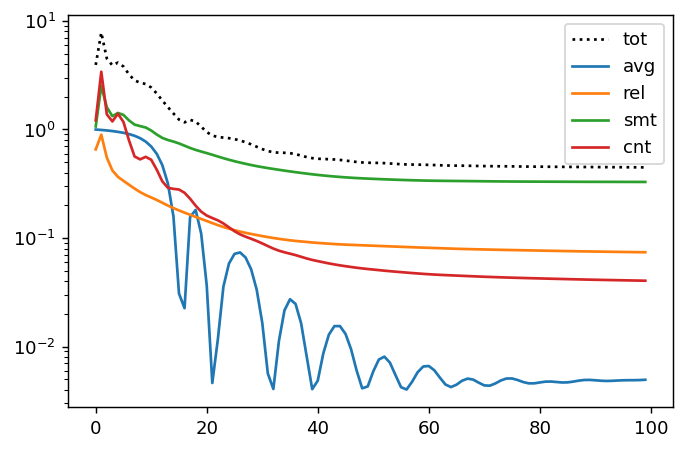

In [33]:
imgs, losses = fit(losses, gmodel_recon,
    N_epochs = 100,
    lr       = 1.0e-1,
    w_avg    = 1.0e+0,
    w_rel    = 1.0e+0,
    w_smt    = 1.0e+0,
    w_cnt    = 1.0e+0,
)
gmodel_recon.model.save('3D_stellar_wind_recon_100.h5')
losses.plot()

Next, we run an additional 500 itereations of the reconstruction algortihm.

100%|██████████| 100/100 [18:03<00:00, 10.84s/it]


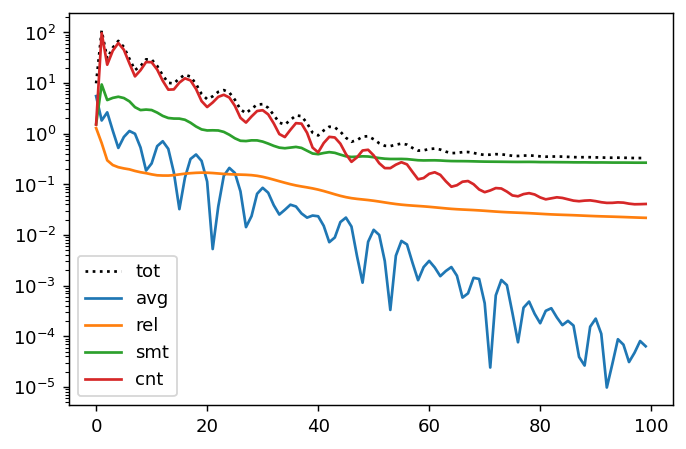

In [ ]:
imgs, losses = fit(losses, gmodel_recon,
    N_epochs = 500,
    lr       = 1.0e-1,
    w_avg    = 1.0e+0,
    w_rel    = 1.0e+0,
    w_smt    = 1.0e+0,
    w_cnt    = 1.0e+0,
)
gmodel_recon.model.save('3D_stellar_wind_recon_600.h5')
losses.plot()